In [5]:
!pip install xgboost pandas numpy matplotlib seaborn scikit-learn joblib tqdm transformers ta

  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=6ddc4ab054b112bfecb9fe05ab62890464442a618c98fbed310e506599a5108d
  Stored in directory: /root/.cache/pip/wheels/5c/a1/5f/c6b85a7d9452057be4ce68a8e45d77ba34234a6d46581777c6
Successfully built ta


In [47]:
# ============================================================
# 🧠 FinBERT + XGBoost Model for Financial Sentiment Forecasting
# ============================================================
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score,
    classification_report, average_precision_score, roc_curve
)
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [50]:
import pandas as pd

# Try reading with multiple strategies
def load_sentiment_file(path):
    encodings = ["utf-8", "ISO-8859-1", "latin1"]
    separators = ["\t", ",", ";", " ", "|"]

    for enc in encodings:
        for sep in separators:
            try:
                df = pd.read_csv(path, sep=sep, encoding=enc)
                # If there are at least 2 columns, success
                if df.shape[1] >= 2:
                    print(f"✅ Loaded with encoding={enc}, sep='{sep}'")
                    df = df.iloc[:, :2]
                    df.columns = ["label", "sentence"]
                    return df
            except Exception:
                continue

    # If still single column, split manually
    print("⚠️ Auto-detect failed — attempting manual split...")
    df = pd.read_csv(path, header=None, encoding="ISO-8859-1")
    df = df[0].astype(str).str.replace("\xa0", " ", regex=False)
    df = df[0].str.split(r"\s+", n=1, expand=True)
    df.columns = ["label", "sentence"]
    return df

# Load the sentiment data safely
sent_df = load_sentiment_file("senti.csv")

# Clean up whitespace & drop missing rows
sent_df["label"] = sent_df["label"].astype(str).str.strip()
sent_df["sentence"] = sent_df["sentence"].astype(str).str.strip()
sent_df = sent_df.dropna(subset=["label", "sentence"]).reset_index(drop=True)

print(f"✅ Final sentiment dataset shape: {sent_df.shape}")
print(sent_df.head(5))


✅ Loaded with encoding=ISO-8859-1, sep=','
✅ Final sentiment dataset shape: (4846, 2)
      label                                           sentence
0   neutral  According to Gran , the company has no plans t...
1   neutral  Technopolis plans to develop in stages an area...
2  negative  The international electronic industry company ...
3  positive  With the new production plant the company woul...
4  positive  According to the company 's updated strategy f...


In [51]:
# ============================================================
# 2️⃣ LOAD FINBERT MODEL FOR EMBEDDINGS
# ============================================================
import torch
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"⚙️ Using device: {device}")

finbert_model = AutoModel.from_pretrained("ProsusAI/finbert")
finbert_tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
finbert_model.to(device)
finbert_model.eval()

⚙️ Using device: cpu


config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [52]:
# ============================================================
# 3️⃣ EXTRACT EMBEDDINGS FROM FINBERT
# ============================================================

def get_embeddings(texts, batch_size=16):
    """Generate [CLS] embeddings for a list of texts using FinBERT."""
    embeddings = []
    with torch.no_grad():
        for i in tqdm(range(0, len(texts), batch_size), desc="🔍 Extracting FinBERT embeddings"):
            batch_texts = texts[i:i + batch_size].tolist()
            enc = finbert_tokenizer(
                batch_texts,
                padding=True,
                truncation=True,
                max_length=128,
                return_tensors="pt"
            ).to(device)
            outputs = finbert_model(**enc)
            cls_embeds = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            embeddings.append(cls_embeds)
    return np.vstack(embeddings)

print("🔄 Generating sentence embeddings...")
X = get_embeddings(sent_df["sentence"])
print(f"✅ Embedding shape: {X.shape}")

🔄 Generating sentence embeddings...



🔍 Extracting FinBERT embeddings: 100%|██████████| 303/303 [13:33<00:00,  2.69s/it]

✅ Embedding shape: (4846, 768)


In [53]:
# ============================================================
# 💾 SAVE FINBERT EMBEDDINGS + SENTIMENT DATA
# ============================================================
import numpy as np
import pandas as pd
import os

# Create directory for embeddings
os.makedirs("finbert_output", exist_ok=True)

# Save embeddings and original sentiment dataframe
embed_path = "finbert_output/finbert_embeddings.npz"
meta_path = "finbert_output/finbert_sentences.csv"

np.savez_compressed(embed_path, embeddings=X)
sent_df.to_csv(meta_path, index=False)

print(f"✅ Saved FinBERT embeddings → {embed_path}")
print(f"✅ Saved metadata (labels, text) → {meta_path}")


✅ Saved FinBERT embeddings → finbert_output/finbert_embeddings.npz
✅ Saved metadata (labels, text) → finbert_output/finbert_sentences.csv


In [124]:
# ============================================================
# 4️⃣ PREPARE LABELS
# ============================================================
from sklearn.model_selection import train_test_split

label_map = {"negative": 0, "neutral": 1, "positive": 2}
y = sent_df["label"].map(label_map).values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"✅ Train set: {X_train.shape}, Test set: {X_test.shape}")

✅ Train set: (3876, 776), Test set: (970, 776)


In [125]:
# ============================================================
# 5️⃣ TRAIN XGBOOST CLASSIFIER
# ============================================================
import xgboost as xgb

xgb_model = xgb.XGBClassifier(
    objective="multi:softprob",
    num_class=3,
    learning_rate=0.05,
    max_depth=6,
    n_estimators=400,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    tree_method="hist",
    random_state=42,
    eval_metric="mlogloss"
)

print("🚀 Training XGBoost model...")
xgb_model.fit(X_train, y_train, eval_set=[(X_test, y_test)], verbose=False)

🚀 Training XGBoost model...


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=400, n_jobs=None, num_class=3, ...)


🔍 Evaluating XGBoost model...

📊 Model Performance:
Accuracy: 0.8979
F1 Score: 0.8981
ROC AUC: 0.9758
PR AUC (Average Precision): 0.9612

📈 Classification Report:
              precision    recall  f1-score   support

    negative       0.85      0.94      0.89       121
     neutral       0.93      0.91      0.92       576
    positive       0.86      0.86      0.86       273

    accuracy                           0.90       970
   macro avg       0.88      0.90      0.89       970
weighted avg       0.90      0.90      0.90       970



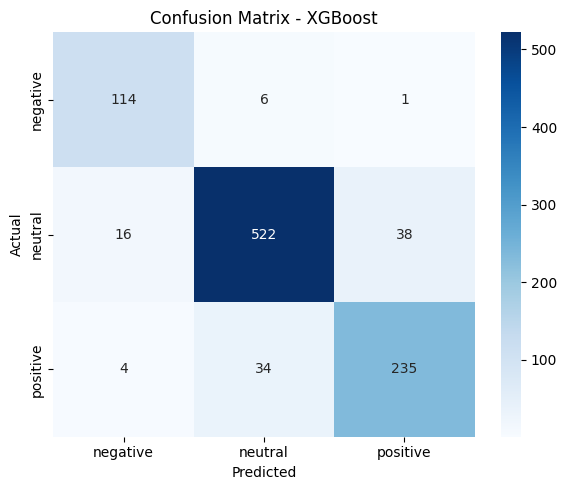

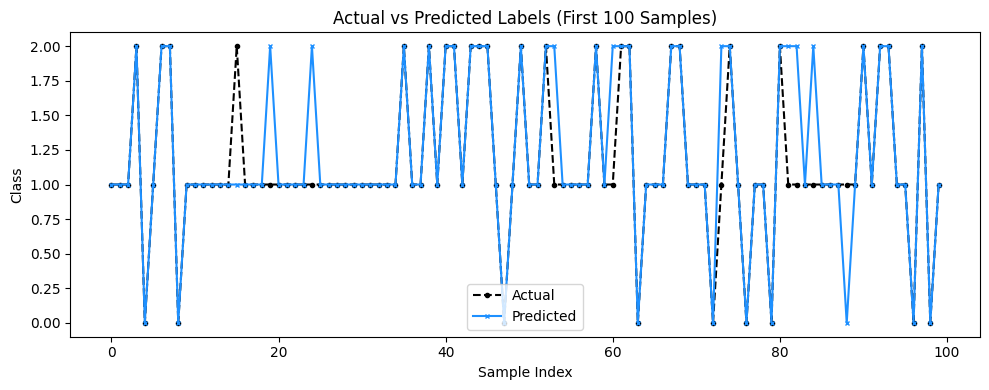

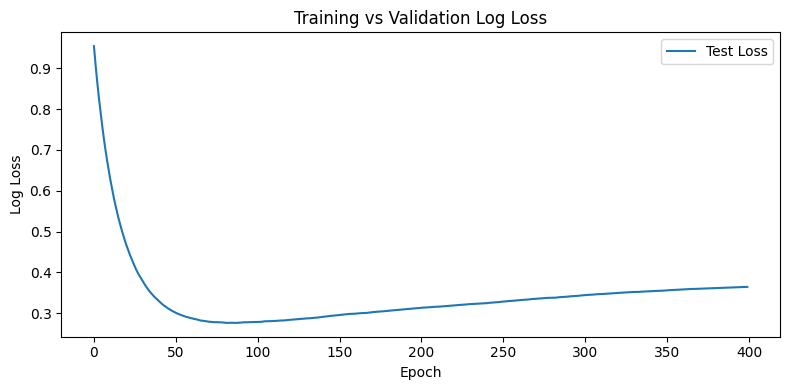


✅ Model saved as 'finbert_xgb_evaluated.pkl'


In [126]:
# ============================================================
# 🧮 Evaluate XGBoost Model — Research-Ready Metrics & Visuals
# ============================================================
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    classification_report, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import joblib

print("\n🔍 Evaluating XGBoost model...")

# ------------------------------------------------------------
# 🔸 Predictions
# ------------------------------------------------------------
y_pred_prob = xgb_model.predict_proba(X_test)
y_pred = np.argmax(y_pred_prob, axis=1) if y_pred_prob.shape[1] > 1 else (y_pred_prob > 0.5).astype(int)

# Convert y_test to one-hot if multiclass
if y_pred_prob.shape[1] > 2:
    y_test_onehot = pd.get_dummies(y_test)
else:
    y_test_onehot = None

# ------------------------------------------------------------
# 🔸 Metrics
# ------------------------------------------------------------
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average="weighted")

# ROC-AUC & PR-AUC (auto-handling binary / multiclass)
try:
    if y_pred_prob.shape[1] > 2:
        roc = roc_auc_score(y_test_onehot, y_pred_prob, multi_class="ovr")
        pr = average_precision_score(y_test_onehot, y_pred_prob, average="weighted")
    else:
        roc = roc_auc_score(y_test, y_pred_prob[:, 1])
        pr = average_precision_score(y_test, y_pred_prob[:, 1])
except Exception:
    roc, pr = np.nan, np.nan

print(f"\n📊 Model Performance:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc:.4f}")
print(f"PR AUC (Average Precision): {pr:.4f}")

# ------------------------------------------------------------
# 🔸 Classification Report
# ------------------------------------------------------------
if "label_encoder" in globals():
    class_names = label_encoder.classes_
else:
    class_names = [str(i) for i in range(y_pred_prob.shape[1])]

print("\n📈 Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names))

# ------------------------------------------------------------
# 🔸 Confusion Matrix Heatmap
# ------------------------------------------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix - XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 🔸 Actual vs Predicted (first 100 samples)
# ------------------------------------------------------------
plt.figure(figsize=(10, 4))
plt.plot(np.arange(100), np.array(y_test)[:100], label="Actual", color="black", linestyle="--", marker="o", markersize=3)
plt.plot(np.arange(100), y_pred[:100], label="Predicted", color="dodgerblue", marker="x", markersize=3)
plt.title("Actual vs Predicted Labels (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Class")
plt.legend()
plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# 🔸 Training vs Validation Log Loss
# ------------------------------------------------------------
try:
    results = xgb_model.evals_result()
    epochs = len(results['validation_0']['mlogloss'])
    x_axis = range(0, epochs)

    plt.figure(figsize=(8, 4))
    plt.plot(x_axis, results['validation_0']['mlogloss'], label='Test Loss')
    if 'validation_1' in results:
        plt.plot(x_axis, results['validation_1']['mlogloss'], label='Train Loss')
    plt.title("Training vs Validation Log Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Log Loss")
    plt.legend()
    plt.tight_layout()
    plt.show()
except Exception:
    print("\n⚠️ Training/validation loss not available — check eval_set usage.")

# ------------------------------------------------------------
# 💾 Save Model
# ------------------------------------------------------------
joblib.dump(xgb_model, "finbert_xgb_evaluated.pkl")
print("\n✅ Model saved as 'finbert_xgb_evaluated.pkl'")


TRY1

In [128]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, average_precision_score, classification_report

# --- Load embeddings ---
emb_path = "/content/finbert_output/finbert_embeddings.npz"
X_text = np.load(emb_path)["embeddings"]

# --- Load stock data ---
stock_df = pd.read_csv("/content/merged_clean.csv")

target_col = "movement"
stock_df = stock_df.iloc[:len(X_text)].reset_index(drop=True)
y = stock_df[target_col].values

# --- Basic numeric features (extend this as you wish) ---
numeric_features = ["open", "high", "low", "close", "volume"]
num_df = stock_df[numeric_features].copy()

# Add engineered features
num_df["return"] = stock_df["close"].pct_change().fillna(0)
num_df["volatility"] = (stock_df["high"] - stock_df["low"]) / stock_df["open"]
num_df["rolling_avg"] = stock_df["close"].rolling(window=5, min_periods=1).mean()

# Scale numeric features
scaler = StandardScaler()
X_num = scaler.fit_transform(num_df)

# Combine sentiment + numeric features
X = np.hstack([X_text, X_num])
print(f"✅ Final feature matrix: {X.shape}")

# ============================================================
# ✂️ Split into training/testing sets
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ============================================================
# 🚀 Train improved XGBoost model
# ============================================================
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    learning_rate=0.03,
    max_depth=8,
    n_estimators=800,
    subsample=0.9,
    colsample_bytree=0.9,
    reg_lambda=1.2,
    reg_alpha=0.4,
    tree_method="hist",
    random_state=42,
    eval_metric="logloss",
)

print("🚀 Training improved XGBoost model...")
xgb_model.fit(X_train, y_train, verbose=False)
print("✅ Training complete!")


✅ Final feature matrix: (4846, 776)
🚀 Training improved XGBoost model...
✅ Training complete!



🔍 Evaluating improved XGBoost model...

📊 Model Performance:
Accuracy: 0.5536
F1 Score: 0.4739
ROC AUC: 0.5505
PR AUC: 0.4777

📈 Classification Report:
              precision    recall  f1-score   support

        Down       0.58      0.65      0.61       524
          Up       0.52      0.44      0.47       446

    accuracy                           0.55       970
   macro avg       0.55      0.54      0.54       970
weighted avg       0.55      0.55      0.55       970



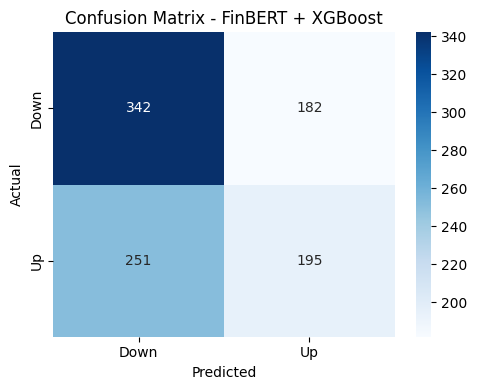

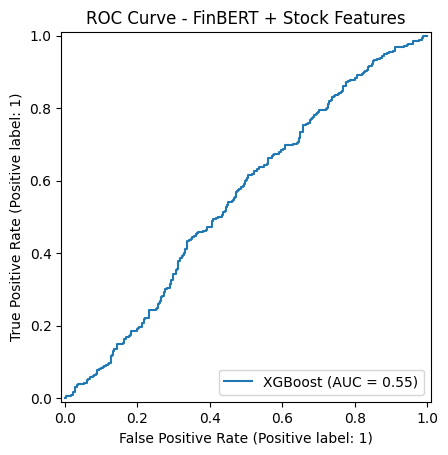

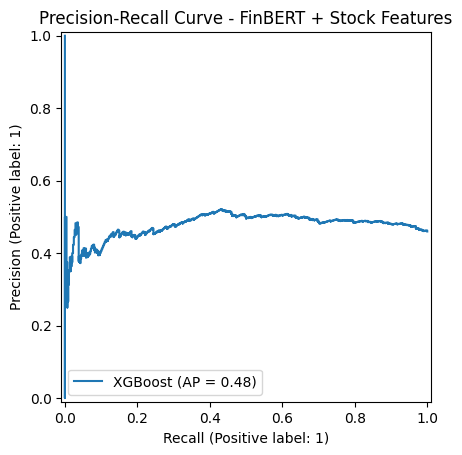

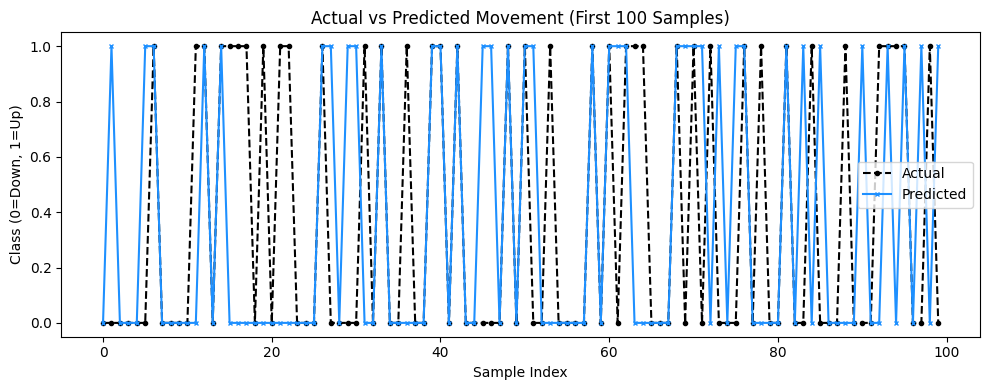

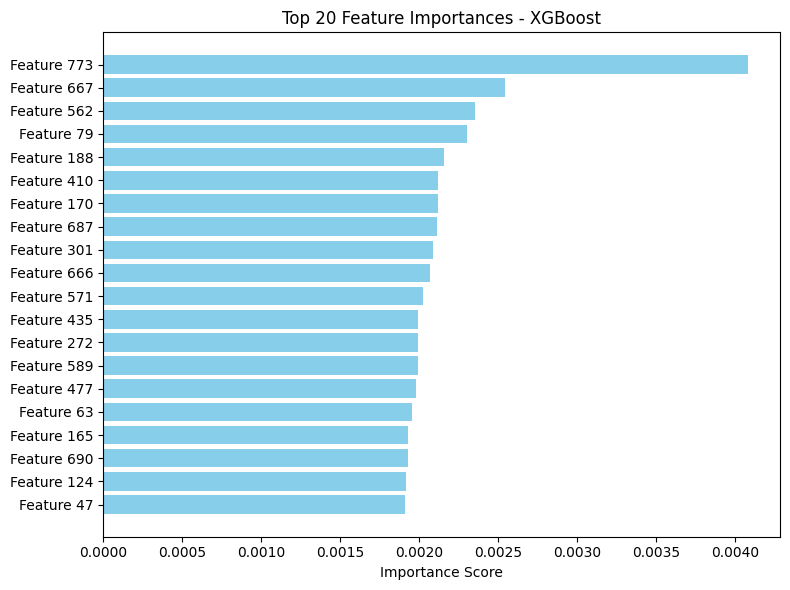


✅ Model and evaluation saved as 'finbert_stock_sentiment_xgb_improved_evaluated.pkl'


In [129]:
# ============================================================
# 🧮 Enhanced Evaluation for FinBERT + XGBoost (Binary Model)
# ============================================================
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, average_precision_score,
    classification_report, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib

print("\n🔍 Evaluating improved XGBoost model...")

# -----------------------------
# 🔹 Predictions & Probabilities
# -----------------------------
y_pred = xgb_model.predict(X_test)
y_prob = xgb_model.predict_proba(X_test)[:, 1]

# -----------------------------
# 🔹 Core Metrics
# -----------------------------
acc = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
pr_auc = average_precision_score(y_test, y_prob)

print("\n📊 Model Performance:")
print(f"Accuracy: {acc:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")
print(f"PR AUC: {pr_auc:.4f}")

# -----------------------------
# 🔹 Classification Report
# -----------------------------
print("\n📈 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Down", "Up"]))

# -----------------------------
# 🔹 Confusion Matrix
# -----------------------------
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Down", "Up"], yticklabels=["Down", "Up"])
plt.title("Confusion Matrix - FinBERT + XGBoost")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# -----------------------------
# 🔹 ROC Curve
# -----------------------------
RocCurveDisplay.from_predictions(y_test, y_prob, name="XGBoost")
plt.title("ROC Curve - FinBERT + Stock Features")
plt.show()

# -----------------------------
# 🔹 Precision-Recall Curve
# -----------------------------
PrecisionRecallDisplay.from_predictions(y_test, y_prob, name="XGBoost")
plt.title("Precision-Recall Curve - FinBERT + Stock Features")
plt.show()

# -----------------------------
# 🔹 Actual vs Predicted (first 100 samples)
# -----------------------------
plt.figure(figsize=(10, 4))
plt.plot(y_test[:100], label="Actual", color="black", linestyle="--", marker="o", markersize=3)
plt.plot(y_pred[:100], label="Predicted", color="dodgerblue", marker="x", markersize=3)
plt.title("Actual vs Predicted Movement (First 100 Samples)")
plt.xlabel("Sample Index")
plt.ylabel("Class (0=Down, 1=Up)")
plt.legend()
plt.tight_layout()
plt.show()

# -----------------------------
# 🔹 Feature Importance (Top 20)
# -----------------------------
plt.figure(figsize=(8, 6))
importance = xgb_model.feature_importances_
indices = np.argsort(importance)[-20:]
plt.barh(range(len(indices)), importance[indices], color='skyblue')
plt.yticks(range(len(indices)), [f"Feature {i}" for i in indices])
plt.title("Top 20 Feature Importances - XGBoost")
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()

# -----------------------------
# 💾 Save Model
# -----------------------------
joblib.dump(xgb_model, "finbert_stock_sentiment_xgb_improved_evaluated.pkl")
print("\n✅ Model and evaluation saved as 'finbert_stock_sentiment_xgb_improved_evaluated.pkl'")
